#### Jupyter Notebook to compute performance metrics from the segmentation predictions.


#### Imports

In [3]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
from skimage import transform
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from shutil import copy
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from scipy.misc import imread, imsave
%matplotlib inline

In [4]:
path_img = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'

In [42]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask[:,:,1] > 200
gt_myelin = np.logical_and(mask[:,:,1] >= 50, mask[:,:,1] <= 200)

pred = imageio.imread(os.path.join(path_folder,'AxonDeepSeg.png'))
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)

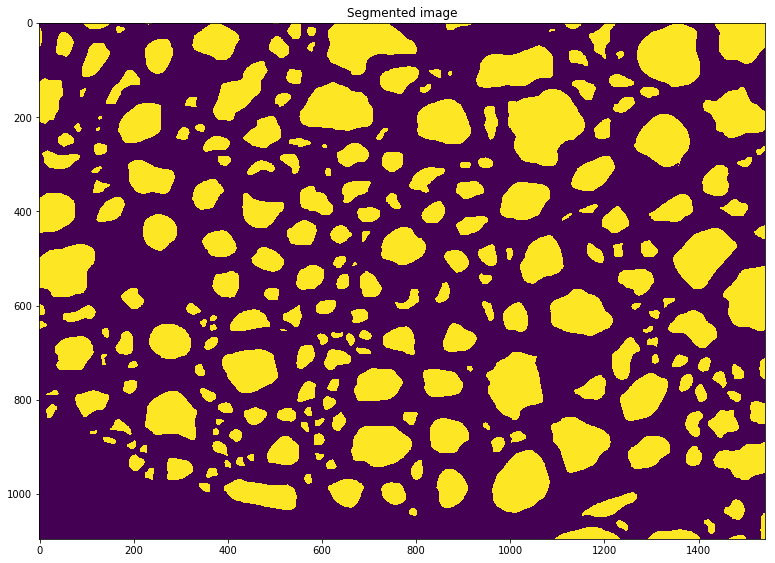

In [49]:
plt.figure(figsize=(13,10))
plt.title('Segmented image')
plt.imshow(gt_axon)
plt.show();

#### Function definitions

In [131]:
class Metrics_calculator: 
    
    def __init__(self, prediction_mask, groundtruth_mask):
        self.prediction_mask = prediction_mask
        self.groundtruth_mask = groundtruth_mask

    def pw_sensitivity(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()

        # Compute positives count (TP+FN)
        P_count = self.groundtruth_mask.sum()
    
        # Compute sensitivity = TP/(TP+FN) = TP/P
        return np.true_divide(TP_count, P_count)
    
    def pw_precision(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()

        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()

        # Compute precision = TP/(TP+FP)
        return np.true_divide(TP_count, (TP_count + FP_count))       
    
    def pw_specificity(self):

        # Compute true negatives count
        TN_count = np.logical_and(self.prediction_mask == 0, self.groundtruth_mask == 0).sum()

        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()

        # Compute specificity = TN/(TN+FP) = TN/N
        return np.true_divide(TN_count, (TN_count + FP_count))    
    
    def pw_FN_rate(self):

        # Compute false negative rate = 1 - sensitivity
        return (1 - self.pw_sensitivity())    
    
    def pw_FP_rate(self):

        # Compute false positive rate = 1 - specificity
        return (1 - self.pw_specificity())

    def pw_accuracy(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()
    
        # Compute true negatives count
        TN_count = np.logical_and(self.prediction_mask == 0, self.groundtruth_mask == 0).sum()
    
        # Compute accuracy = (TP+TN)/total_count
        return np.true_divide((TN_count+TP_count), self.prediction_mask.size)

    def pw_F1_score(self):

        # Compute F1 score = 2*(precision*sensitivity)/(precision+sensitivity)
        return np.true_divide(2*(self.pw_sensitivity()*self.pw_precision()),(self.pw_sensitivity()+self.pw_precision()))

    def pw_dice(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()
        
        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute false negatives count
        FN_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute Dice = 2TP/(2TP+FP+FN)
        return np.true_divide(2*TP_count,2*TP_count+FP_count+FN_count)
    
    def pw_jaccard(self):

        # Compute true positives count
        TP_count = np.logical_and(self.prediction_mask, self.groundtruth_mask).sum()
        
        # Compute false positives count
        FP_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute false negatives count
        FN_count = np.logical_and(self.prediction_mask == 1, self.groundtruth_mask == 0).sum()
    
        # Compute Jaccard = TP/(TP+FP+FN)
        return np.true_divide(TP_count,TP_count+FP_count+FN_count)


In [133]:
pw_metrics = Metrics_calculator(pred_axon, gt_axon)
print(pw_metrics.pw_sensitivity())
print(pw_metrics.pw_accuracy())
print(pw_metrics.pw_dice())
print(pw_metrics.pw_F1_score())
print(pw_metrics.pw_FN_rate())
print(pw_metrics.pw_FP_rate())
print(pw_metrics.pw_jaccard())
print(pw_metrics.pw_precision())
print(pw_metrics.pw_specificity())

0.9076187907633985
0.9537424745520257
0.9418834752444024
0.9244337317700222
0.09238120923660154
0.025366003052247788
0.8901509930222075
0.9418834752444024
0.9746339969477522


In [134]:
pw_metrics = Metrics_calculator(pred_myelin, gt_myelin)
print(pw_metrics.pw_sensitivity())
print(pw_metrics.pw_accuracy())
print(pw_metrics.pw_dice())
print(pw_metrics.pw_F1_score())
print(pw_metrics.pw_FN_rate())
print(pw_metrics.pw_FP_rate())
print(pw_metrics.pw_jaccard())
print(pw_metrics.pw_precision())
print(pw_metrics.pw_specificity())

0.8394451437143301
0.8892687467139074
0.8383119186436943
0.8388781484659577
0.1605548562856699
0.08467437234324582
0.7216325381120721
0.8383119186436943
0.9153256276567542
